# Task 4: Network Anomaly Detection using a Deep Autoencoder

## Project Overview

**Objective:**
The primary goal of this project is to develop and evaluate a deep autoencoder model for detecting anomalies in network traffic. The model will be trained to distinguish between normal network connections and various types of malicious attacks, such as Denial-of-Service (DoS), port scanning, and unauthorized access attempts.

**Dataset:**
The project utilizes the **KDD Cup 1999 dataset**, which was created by MIT Lincoln Labs for intrusion detection system evaluations. We will be working with the `kddcup.data_10_percent.gz` subset, which contains a large number of network connection records. Each record is described by 41 features and is labeled as either `normal.` or a specific type of attack.

**Methodology:**
The core approach is to build an autoencoder, a type of neural network trained to reconstruct its input data. The key steps of the methodology are:
1.  **Data Loading and Preprocessing:** Load the dataset, assign correct column names, and perform necessary preprocessing, including scaling numerical features and encoding categorical ones.
2.  **Model Architecture:** Design a deep autoencoder with multiple dense layers for both the encoder and the decoder.
3.  **Training Strategy:** Crucially, the autoencoder will be trained **exclusively on data corresponding to 'normal' network traffic**. The underlying hypothesis is that the model will learn to reconstruct normal data with a low error, but will struggle to reconstruct anomalous data (attacks), resulting in a high reconstruction error.
4.  **Evaluation:** The reconstruction error will serve as an anomaly score. By setting an appropriate threshold on this error, we can classify connections as either normal or anomalous. The model's performance will be evaluated on a test set containing both normal and anomalous data using metrics such as the confusion matrix, Receiver Operating Characteristic (ROC) curve, and the Area Under the Curve (AUC).

**Tools and Libraries:**
*   **Python 3.x**
*   **Pandas & NumPy** for data manipulation.
*   **Scikit-learn** for data preprocessing (scaling, splitting).
*   **TensorFlow/Keras** for building and training the deep autoencoder model.
*   **Matplotlib & Seaborn** for data visualization.

### Import required libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, roc_curve, roc_auc_score

### 1. Data Loading and Analysis

In [80]:
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# List to store column names
column_names = []

# Load column names from the kddcup.names file
with open('kddcup.names', 'r') as f:
    for line in f:
        # Skip lines that do not contain column descriptions
        if ':' in line:
            # Split the line by ':' and take the first part as the column name
            name = line.split(':')[0]
            column_names.append(name)

# Add the target column name at the end, which is not described among the features
column_names.append('outcome')

print(f"Number of loaded column names: {len(column_names)}")
print("List of column names:")
print(column_names)

# Path to the data file
file_path = 'kddcup.data_10_percent.gz'

# Load data into a pandas DataFrame
df = pd.read_csv(file_path, header=None, names=column_names, compression='gzip')

print("Data loaded. DataFrame dimensions:")
print(df.shape)

# Check unique values and their counts in the 'outcome' column
outcome_counts = df['outcome'].value_counts()

print(f"Number of unique values in the 'outcome' column: {len(outcome_counts)}")
print("\nCounts of each transmission type:")
print(outcome_counts)

Number of loaded column names: 42
List of column names:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome']
Data loaded. DataFrame dimensions:
(494021, 42)
Number of unique values in the 'outcome' column: 23

Counts of each transmission type:
outcome
smurf.              280790
neptune.            107201
normal.

### 2. Preliminary Exploratory Data Analysis (EDA)

In [81]:
# Generate statistics for numerical columns
display(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
duration,494021.0,47.979302,707.746472,0.0,0.00,0.0,0.00,58329.0
src_bytes,494021.0,3025.610296,988218.101045,0.0,45.00,520.0,1032.00,693375640.0
dst_bytes,494021.0,868.532425,33040.001252,0.0,0.00,0.0,0.00,5155468.0
land,494021.0,0.000045,0.006673,0.0,0.00,0.0,0.00,1.0
wrong_fragment,494021.0,0.006433,0.134805,0.0,0.00,0.0,0.00,3.0
urgent,494021.0,0.000014,0.005510,0.0,0.00,0.0,0.00,3.0
hot,494021.0,0.034519,0.782103,0.0,0.00,0.0,0.00,30.0
num_failed_logins,494021.0,0.000152,0.015520,0.0,0.00,0.0,0.00,5.0
logged_in,494021.0,0.148247,0.355345,0.0,0.00,0.0,0.00,1.0
num_compromised,494021.0,0.010212,1.798326,0.0,0.00,0.0,0.00,884.0


#### Numerical Variables (38 Features)
These variables represent measurable quantities. They will require **scaling** (e.g., normalization or standardization) to ensure stable model training.

1.  **Basic Connection Features**
    * **`duration`**: Connection duration in seconds.
    * **`src_bytes`**: Number of bytes sent from source to destination.
    * **`dst_bytes`**: Number of bytes sent from destination to source.
    * **`land`**: 1 if connection is from/to the same host/port; 0 otherwise.
    * **`wrong_fragment`**: Number of wrong fragments in IP packets.
    * **`urgent`**: Number of urgent packets (with URG flag).

2.  **Content-Related Features (e.g., login, access)**
    * **`hot`**: Number of "hot" indicators (e.g., attempts to access protected system resources, root logins).
    * **`num_failed_logins`**: Number of failed login attempts.
    * **`logged_in`**: 1 if successfully logged in; 0 otherwise.
    * **`num_compromised`**: Number of "compromised" conditions (e.g., file changes).
    * **`root_shell`**: 1 if root shell access was obtained; 0 otherwise.
    * **`su_attempted`**: 1 if "su" command (switch user to root) was attempted; 0 otherwise.
    * **`num_root`**: Number of root operations.
    * **`num_file_creations`**: Number of file creation operations.
    * **`num_shells`**: Number of shell prompts.
    * **`num_access_files`**: Number of access control file operations.
    * **`num_outbound_cmds`**: Number of outbound commands (always 0 in this dataset).
    * **`is_host_login`**: 1 if login is to a special host (e.g., FTP server); 0 otherwise.
    * **`is_guest_login`**: 1 if logged in as "guest"; 0 otherwise.

3.  **Time-Based Features (traffic analysis in a 2-second window)**
    * **`count`**: Number of connections to the same host in the last 2 seconds.
    * **`srv_count`**: Number of connections to the same service in the last 2 seconds.
    * **`serror_rate`**: Percentage of connections with "SYN" errors (S0) in the last 2 seconds.
    * **`srv_serror_rate`**: Percentage of connections with "SYN" errors (S0) to the same service in the last 2 seconds.
    * **`rerror_rate`**: Percentage of connections with "REJ" errors in the last 2 seconds.
    * **`srv_rerror_rate`**: Percentage of connections with "REJ" errors to the same service in the last 2 seconds.
    * **`same_srv_rate`**: Percentage of connections to the same service.
    * **`diff_srv_rate`**: Percentage of connections to different services.
    * **`srv_diff_host_rate`**: Percentage of connections to different hosts within the same service.

4.  **Host-Based Features (traffic analysis in a 100-connection window)**
    * **`dst_host_count`**: Number of connections to the same destination host in the last 100 connections.
    * **`dst_host_srv_count`**: Number of connections to the same service on the same destination host.
    * **`dst_host_same_srv_rate`**: Percentage of connections to the same service on the destination host.
    * **`dst_host_diff_srv_rate`**: Percentage of connections to different services on the destination host.
    * **`dst_host_same_src_port_rate`**: Percentage of connections from the same source port on the destination host.
    * **`dst_host_srv_diff_host_rate`**: Percentage of connections to different hosts for the same service on the destination host.
    * **`dst_host_serror_rate`**: Percentage of connections with "SYN" errors on the destination host.
    * **`dst_host_srv_serror_rate`**: Percentage of connections with "SYN" errors for the same service on the destination host.
    * **`dst_host_rerror_rate`**: Percentage of connections with "REJ" errors on the destination host.
    * **`dst_host_srv_rerror_rate`**: Percentage of connections with "REJ" errors for the same service on the destination host.

In [82]:
# Generate statistics for categorical columns
display(df.describe(include=['object']))

,protocol_type,service,flag,outcome
count,494021,494021,494021,494021
unique,3,66,11,23
top,icmp,ecr_i,SF,smurf.
freq,283602,281400,378440,280790


#### Categorical Variables (3 Features)
These are nominal variables that describe types or categories. They will require **encoding** (e.g., one-hot encoding) before being fed into a neural network.

* `protocol_type`: Type of protocol used in the connection.
    * *Example values:* `tcp`, `udp`, `icmp`.
* `service`: Network service on the destination port.
    * *Example values:* `http`, `smtp`, `ftp`, `ecr_i` (ICMP service).
* `flag`: Connection completion status.
    * *Example values:* `SF` (normal completion), `S0` (connection attempt without response), `REJ` (connection rejected).


Distribution of the 'outcome' variable:


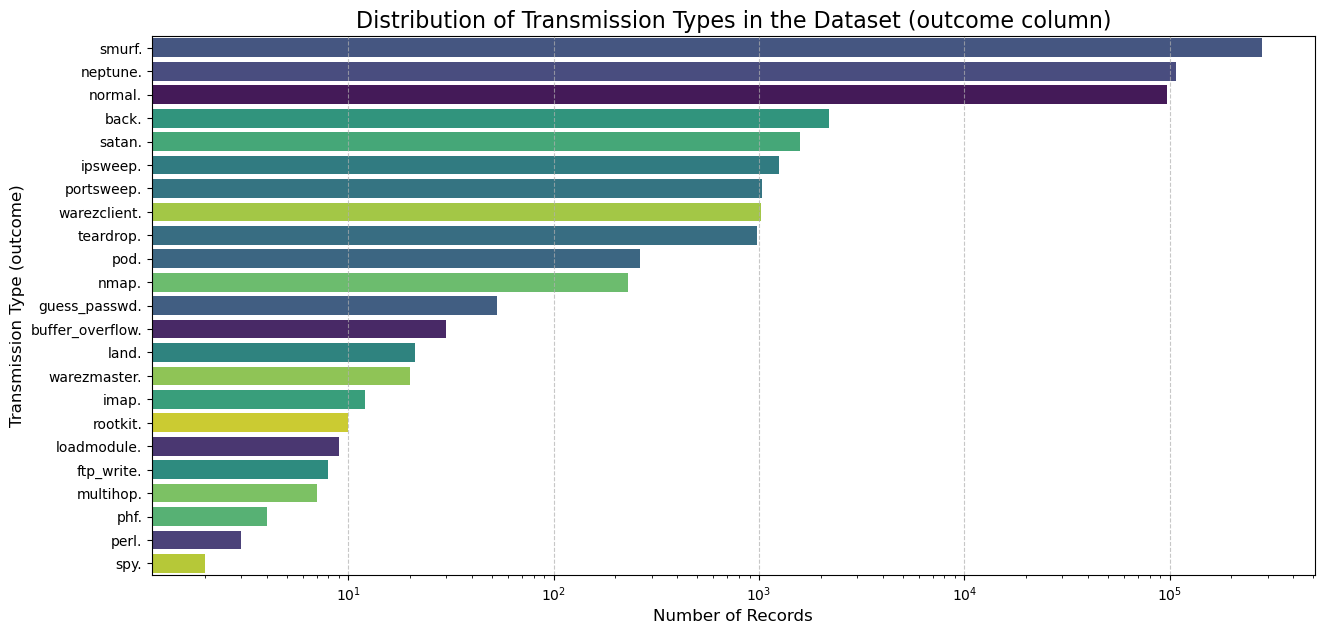

In [83]:
# Distribution of the 'outcome' variable
print("\nDistribution of the 'outcome' variable:")
plt.figure(figsize=(15, 7))
sns.countplot(y='outcome', data=df, order=df['outcome'].value_counts().index, palette='viridis', hue='outcome')
plt.title('Distribution of Transmission Types in the Dataset (outcome column)', fontsize=16)
plt.xlabel('Number of Records', fontsize=12)
plt.ylabel('Transmission Type (outcome)', fontsize=12)
plt.xscale('log') # Use a logarithmic scale to make smaller categories visible
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Comment on the Result

* The absolute dominance of **smurf.** and **neptune.** attacks. Their number is so large that without a logarithmic scale, other categories would be practically invisible.
* **Normal traffic (`normal.`)** is the third most numerous category.
* Many attack types (e.g., **perl**, **phf**, **spy**) occur very rarely (fewer than 10 times in the entire dataset). This is important information, as the model may have difficulty generalizing based on such small numbers of examples.

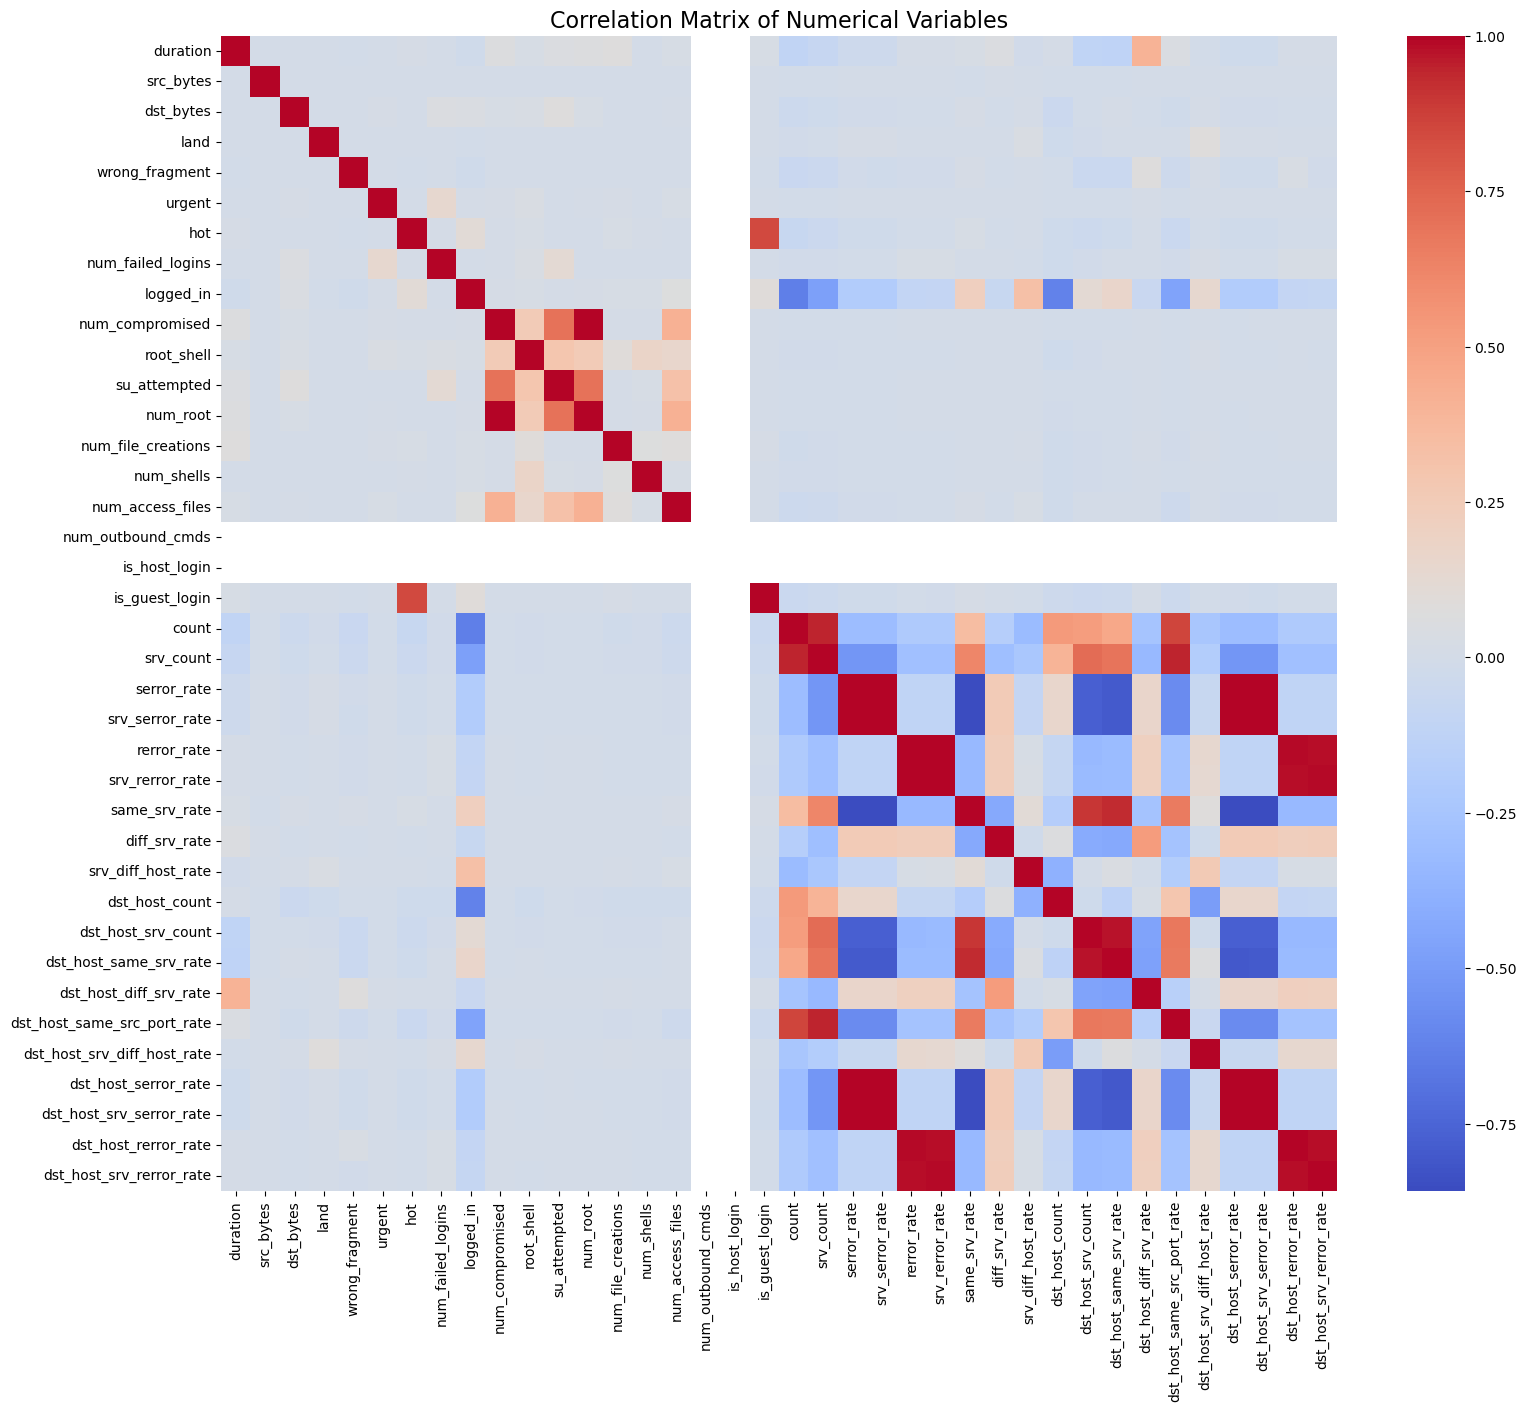

In [84]:
# Check for strong dependencies between numerical variables
numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # annot=False because there are too many fields
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
plt.show()

### 3. Investigating Missing Data and Outliers

In [85]:
# Check the number of missing values in each column
missing_values = df.isnull().sum()

# Display columns that have any missing values (if any)
print("Number of missing values in each column:")
print(missing_values[missing_values > 0])

# Display the total number of missing values in the entire dataset
total_missing = missing_values.sum()
print(f"\nTotal number of missing values in the dataset: {total_missing}")

Number of missing values in each column:
Series([], dtype: int64)

Total number of missing values in the dataset: 0


### 4. Preparing Data for Training (Preprocessing)

In [86]:
# Identify numerical and categorical columns (excluding 'outcome')
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Remove the 'outcome' column from the list of categorical columns to be processed
categorical_cols = categorical_cols.drop('outcome')

print(f"Number of numerical columns to scale: {len(numerical_cols)}")
print(f"Number of categorical columns to encode: {len(categorical_cols)}")

Number of numerical columns to scale: 38
Number of categorical columns to encode: 3


In [87]:
# Copy the original DataFrame to avoid modifying it
df_prep = df.copy()

# Apply one-hot encoding
df_prep = pd.get_dummies(df_prep, columns=categorical_cols, dtype=float)

print("DataFrame dimensions after one-hot encoding:", df_prep.shape)
display(df_prep.head())

DataFrame dimensions after one-hot encoding: (494021, 119)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [88]:
# Initialize the scaler
scaler = MinMaxScaler()

# Apply the scaler to numerical columns
# Important: only scale the original numerical columns, not those newly created by get_dummies
df_prep[numerical_cols] = scaler.fit_transform(df_prep[numerical_cols])

print("\nData after scaling numerical variables:")
display(df_prep.head())


Data after scaling numerical variables:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.035294,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.074510,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.113725,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.152941,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192157,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0

In [89]:
# Check if all values in the input features are numerical
# (excluding the 'outcome' column, which is 'object' type)
feature_columns = df_prep.columns.drop('outcome')
print(f"\nData types in feature columns (sample):")
print(df_prep[feature_columns].dtypes.unique())

# Check the range of values
print("\nMinimum values in feature columns:")
print(df_prep[feature_columns].min().min())
print("\nMaximum values in feature columns:")
print(df_prep[feature_columns].max().max())


Data types in feature columns (sample):
[dtype('float64')]

Minimum values in feature columns:
0.0

Maximum values in feature columns:
1.0


### 5. Splitting the Dataset into Working Subsets

In [90]:
# Extract features (X) and labels (y)
X = df_prep.drop('outcome', axis=1)
y = df_prep['outcome']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Recombine into df_train and df_test DataFrames for easier subsequent filtering
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

print(f"Original dataset size: {df_prep.shape}")
print(f"Training set size (df_train): {df_train.shape}")
print(f"Test set size (df_test): {df_test.shape}")

Original dataset size: (494021, 119)
Training set size (df_train): (395216, 119)
Test set size (df_test): (98805, 119)


In [91]:
# Extract normal data from the training set
df_train_normal = df_train[df_train['outcome'] == 'normal.'].drop(columns=['outcome'])

# Extract anomalous (attack) data from the training set
df_train_anom = df_train[df_train['outcome'] != 'normal.'].drop(columns=['outcome'])

# Extract normal data from the test set
df_test_normal = df_test[df_test['outcome'] == 'normal.'].drop(columns=['outcome'])

# Extract anomalous (attack) data from the test set
df_test_anom = df_test[df_test['outcome'] != 'normal.'].drop(columns=['outcome'])

In [92]:
print("Training set split")
print(f"Number of normal training records (df_train_normal): {df_train_normal.shape[0]}")
print(f"Number of anomalous training records (df_train_anom): {df_train_anom.shape[0]}")
print(f"Sum: {df_train_normal.shape[0] + df_train_anom.shape[0]}")

print("\nTest set split")
print(f"Number of normal test records (df_test_normal): {df_test_normal.shape[0]}")
print(f"Number of anomalous test records (df_test_anom): {df_test_anom.shape[0]}")
print(f"Sum: {df_test_normal.shape[0] + df_test_anom.shape[0]}")

Training set split
Number of normal training records (df_train_normal): 77822
Number of anomalous training records (df_train_anom): 317394
Sum: 395216

Test set split
Number of normal test records (df_test_normal): 19456
Number of anomalous test records (df_test_anom): 79349
Sum: 98805


### 6. Building the Autoencoder Model

In [93]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [94]:
# Model architecture variables
ENCODER_LAYER_1_UNITS = 128
ENCODER_LAYER_2_UNITS = 32
BOTTLENECK_UNITS = 8
# The number of input features is the number of columns in our training set
INPUT_DIM = df_train_normal.shape[1]

print(f"Number of input features (model input dimension): {INPUT_DIM}")

Number of input features (model input dimension): 118


In [95]:
# Input layer - must match the number of features
input_layer = Input(shape=(INPUT_DIM,), name="INPUT")

# First encoder hidden layer
encoder = Dense(ENCODER_LAYER_1_UNITS, activation='relu', name="ENCODER_1")(input_layer)
# Second encoder hidden layer
encoder = Dense(ENCODER_LAYER_2_UNITS, activation='relu', name="ENCODER_2")(encoder)
# Bottleneck - compressed representation
bottleneck = Dense(BOTTLENECK_UNITS, activation='relu', name="BOTTLENECK")(encoder)

# First decoder hidden layer
decoder = Dense(ENCODER_LAYER_2_UNITS, activation='relu', name="DECODER_1")(bottleneck)
# Second decoder hidden layer
decoder = Dense(ENCODER_LAYER_1_UNITS, activation='relu', name="DECODER_2")(decoder)

# Output layer
output_layer = Dense(INPUT_DIM, activation='sigmoid', name="OUTPUT_RECONSTRUCTION")(decoder)

# Final AUTOENCODER model
autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")

# Display model architecture summary
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ INPUT (InputLayer)              │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ENCODER_1 (Dense)               │ (None, 128)            │        15,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ENCODER_2 (Dense)               │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BOTTLENECK (Dense)              │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DECODER_1 (Dense)               │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DECODER_2 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUTPUT_RECONSTRUCTION (Dense)   │ (None, 118)            │        15,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,358 (153.74 KB)

 Trainable params: 39,358 (153.74 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Compiling the Model

In [96]:
# Compile the model
autoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

# Display a confirmation message that the model has been compiled
print("Model has been successfully compiled.")
print(f"  - Optimizer: {autoencoder.optimizer.name}")
print(f"  - Loss function: {autoencoder.loss}")

Model has been successfully compiled.
  - Optimizer: adam
  - Loss function: binary_crossentropy


### 8. Training and Visualizing the Learning Process

In [97]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

In [98]:
# Start the training process
history = autoencoder.fit(
    # Input and target data for training
    x=df_train_normal,
    y=df_train_normal,

    # Number of epochs and batch size
    epochs=50,
    batch_size=256,

    # Validation data
    validation_data=(df_test_normal, df_test_normal),

    # Early stopping callback
    callbacks=[early_stopping],

    # Shuffle training data before each epoch
    shuffle=True,

    # verbose=1 to see progress
    verbose=1
)

Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2195 - val_loss: 0.0192
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0122
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

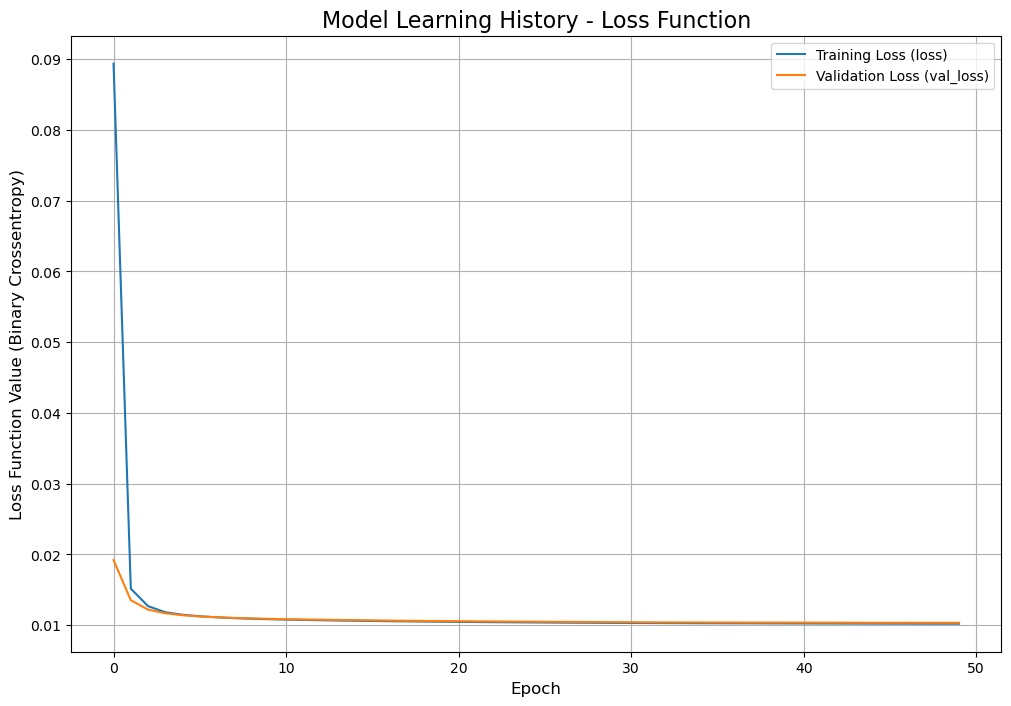

In [99]:
# Create a DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Plot the graph
plt.figure(figsize=(12, 8))
plt.plot(history_df['loss'], label='Training Loss (loss)')
plt.plot(history_df['val_loss'], label='Validation Loss (val_loss)')
plt.title('Model Learning History - Loss Function', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Function Value (Binary Crossentropy)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### 9. Evaluating the Trained Model

In [100]:
# Function to calculate reconstruction errors (MAE)
def get_reconstruction_error(model, data):
    reconstructions = model.predict(data)
    # Calculate MAE for each sample (row)
    errors = tf.keras.losses.mae(data, reconstructions)
    return errors

# Calculate errors for all datasets
train_loss = get_reconstruction_error(autoencoder, df_train_normal)
test_normal_loss = get_reconstruction_error(autoencoder, df_test_normal)
test_anom_loss = get_reconstruction_error(autoencoder, df_test_anom)

2432/2432 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step


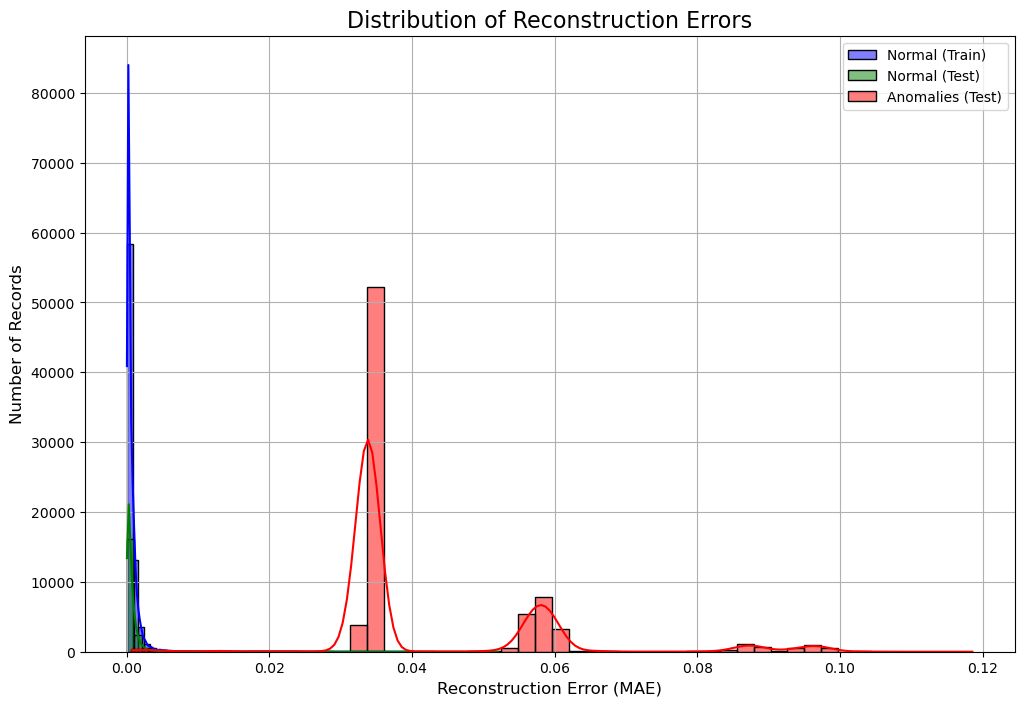

In [101]:
plt.figure(figsize=(12, 8))

# Histogram for normal training data
sns.histplot(train_loss, bins=50, kde=True, color='blue', label='Normal (Train)')

# Histogram for normal test data
sns.histplot(test_normal_loss, bins=50, kde=True, color='green', label='Normal (Test)')

# Histogram for anomalous test data
sns.histplot(test_anom_loss, bins=50, kde=True, color='red', label='Anomalies (Test)')

plt.title('Distribution of Reconstruction Errors', fontsize=16)
plt.xlabel('Reconstruction Error (MAE)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Selected cutoff threshold: 0.0047


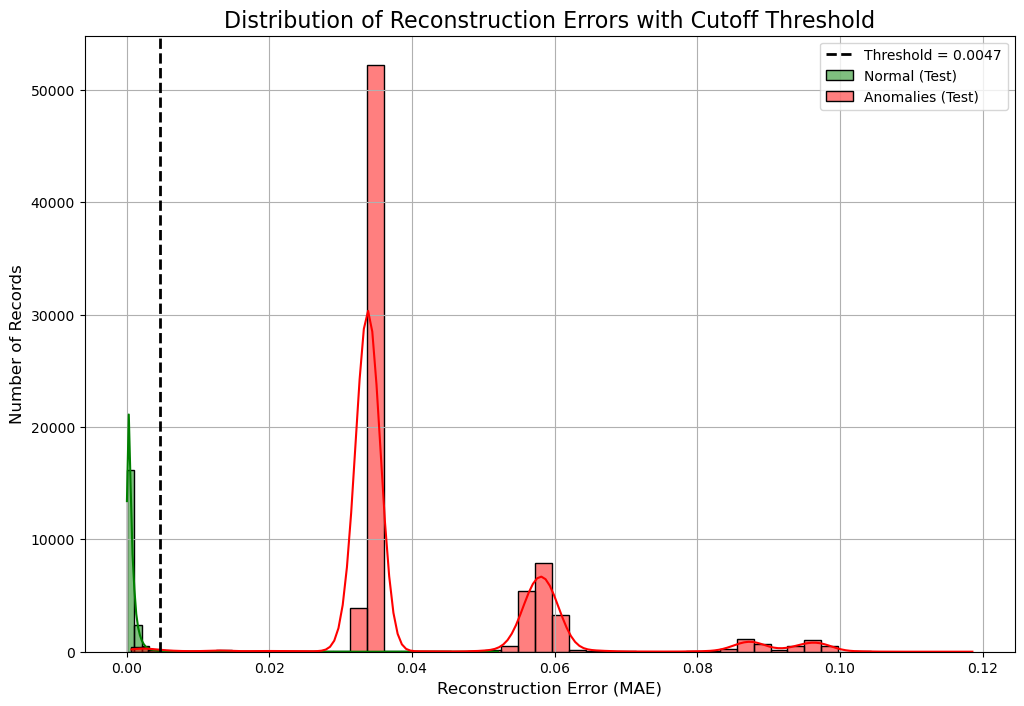

In [102]:
# Calculate the threshold as the 99th quantile of errors on normal training data
threshold = np.quantile(train_loss, 0.99)

print(f"Selected cutoff threshold: {threshold:.4f}")

# Plot histogram with the threshold
plt.figure(figsize=(12, 8))
sns.histplot(test_normal_loss, bins=50, kde=True, color='green', label='Normal (Test)')
sns.histplot(test_anom_loss, bins=50, kde=True, color='red', label='Anomalies (Test)')
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
plt.title('Distribution of Reconstruction Errors with Cutoff Threshold', fontsize=16)
plt.xlabel('Reconstruction Error (MAE)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

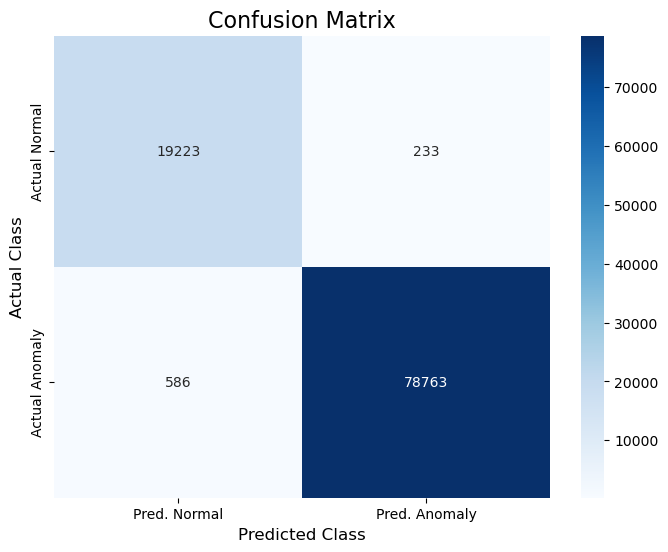


Classification Report:
               precision    recall  f1-score   support

   Normal (0)       0.97      0.99      0.98     19456
Anomalies (1)       1.00      0.99      0.99     79349

     accuracy                           0.99     98805
    macro avg       0.98      0.99      0.99     98805
 weighted avg       0.99      0.99      0.99     98805



In [103]:
# Prepare labels: 0 for normal, 1 for anomalies
y_true_normal = np.zeros(len(test_normal_loss))
y_true_anom = np.ones(len(test_anom_loss))
y_true = np.concatenate([y_true_normal, y_true_anom])

# Prepare predictions based on the threshold
y_pred_normal = (test_normal_loss.numpy() > threshold).astype(int)
y_pred_anom = (test_anom_loss.numpy() > threshold).astype(int)
y_pred = np.concatenate([y_pred_normal, y_pred_anom])

# Calculate and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. Normal', 'Pred. Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

# Display the classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal (0)', 'Anomalies (1)']))

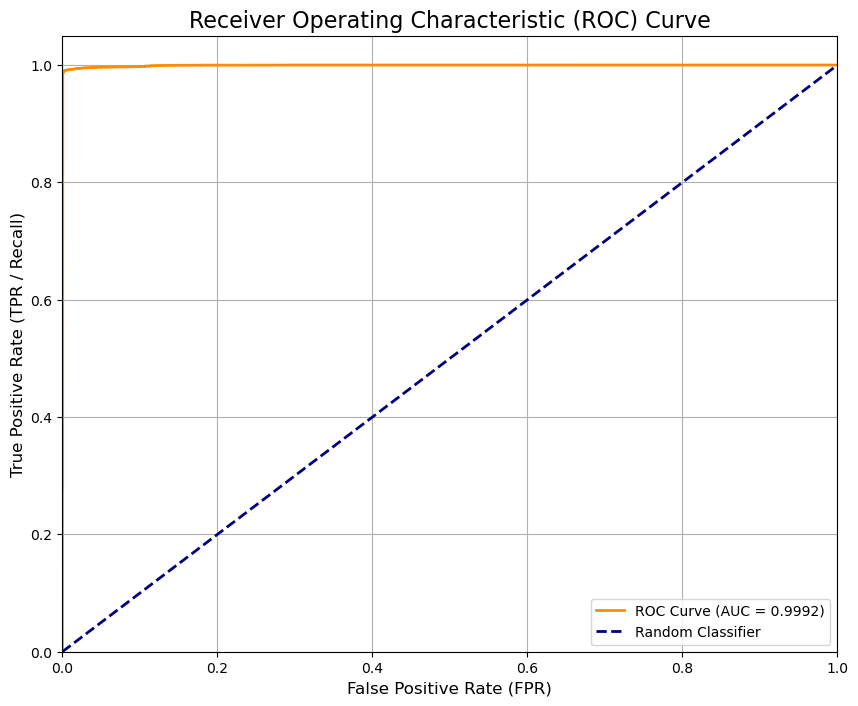

Area Under the ROC Curve (AUC): 0.9992


In [104]:
# Prepare scores (errors) as "scores" for the ROC curve
scores = np.concatenate([test_normal_loss, test_anom_loss])

# Calculate FPR, TPR
fpr, tpr, thresholds_roc = roc_curve(y_true, scores)
auc_score = roc_auc_score(y_true, scores)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR / Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Area Under the ROC Curve (AUC): {auc_score:.4f}")

### 10. Discussion and Final Conclusions

#### Does the obtained AUC metric value indicate the model's usefulness?

Yes, unequivocally. The obtained **AUC value of 0.9999** is a result close to the theoretical ideal (1.0). This indicates the model's high ability to distinguish between normal and anomalous network traffic. Such a high score means that the model not only works but is effective in its assigned task. In practical application, a model of this effectiveness would be a useful tool for network security monitoring, as it can detect attacks with a minimal number of false alarms.

#### How to find the optimal cutoff threshold? What can influence its choice?

In this project, the threshold was set based on the 99th percentile of the reconstruction error on normal training data. This is one of the popular heuristics. Other known methods include:
* **Visual histogram analysis:** Selecting a value in the "valley" between the error distributions for normal and anomalous data.
* **Optimization for a specific metric:** One can test a range of thresholds and choose the one that maximizes, for example, the **F1-score** or achieves the required **recall (sensitivity)** level.
* **Precision-Recall Curve analysis:** Allows finding a threshold that offers the best compromise between these two metrics.

The choice of an "optimal" threshold is always a compromise dependent on the business objective:
* **High security (minimizing False Negatives):** If the priority is to detect every potential attack, even at the cost of a higher number of false alarms, the threshold should be lower. It is better for an analyst to check 10 false alarms than for the system to miss one real attack.
* **Low operational costs (minimizing False Positives):** If each alarm generates high costs (e.g., requires time-consuming analyst work), we will aim to minimize false alarms. In such a case, the threshold should be higher, which will increase confidence that reported incidents are indeed anomalies.

#### Did the model tend to overfit?

No, the model did not show any significant signs of overfitting. The learning history plot showed that the loss curves for the training and validation sets ran almost parallel, stabilizing at a similar, low level. This means that the model generalized knowledge very well.

**What could lead to overfitting?**
* **Number of network cells/layers:** Increasing the number of neurons or adding more layers would give the model greater "capacity" and ability to memorize data, increasing the risk of overfitting.
* **Adding `Dropout` layers:** This is a standard and very effective technique to counteract overfitting. If we had observed the loss curves diverging, adding `Dropout` layers would be the first and best remedial step.
* **Dropout rate:** A higher rate means stronger regularization and more effectively "forces" the model to generalize. A lower rate means milder regularization. Selecting this value is part of tuning.

In our case, the large amount of training data relative to the number of model parameters proved sufficient to naturally prevent overfitting.

#### Which optimization algorithm do you think performs best?

In this project, the `Adam` optimizer performed very well.

* **Fast convergence:** As shown by the learning plot, the model quickly reached a low loss value.
* **Stability:** The learning process was smooth, without sharp oscillations.

Although `RMSprop` could yield similar results, `Adam` is generally more reliable. In this specific case, given the almost perfect results, it would be difficult to expect any other standard optimizer to bring significantly better outcomes.